In [2]:
#General
import pandas as pd
import numpy as np
import json

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

import torch

# Geolocation
from geopy.geocoders import Nominatim

# Options
pd.set_option('display.max_columns', 100)

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [4]:
# Helper functions
def display_df(df, name):
    '''Display df shape and first row '''
    f'{name} data has {df.shape[0]} rows and {df.shape[1]} columns. \n ===> First row:'
    display(df.head(1))

In [5]:
DATA_DIR = "/kaggle/input/predict-energy-behavior-of-prosumers/"

# Read CSVs and parse relevant date columns
train = pd.read_csv(DATA_DIR + "train.csv")
client = pd.read_csv(DATA_DIR + "client.csv")
historical_weather = pd.read_csv(DATA_DIR + "historical_weather.csv")
forecast_weather = pd.read_csv(DATA_DIR + "forecast_weather.csv")
electricity = pd.read_csv(DATA_DIR + "electricity_prices.csv")
gas = pd.read_csv(DATA_DIR + "gas_prices.csv")

location = (pd.read_csv("/kaggle/input/fabiendaniels-mapping-locations-and-county-codes/county_lon_lats.csv")
            .drop(columns = ["Unnamed: 0"])
           )

In [6]:
display_df(train, 'train')
display_df(client, 'client')
display_df(historical_weather, 'historical weather')
display_df(forecast_weather, 'forecast weather')
display_df(electricity, 'electricity prices')
display_df(gas, 'gas prices')
display_df(location, 'location data')

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0


,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2


,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01 00:00:00,14.2,11.6,0.0,0.0,1015.9,31,31,0,11,7.083333,8,0.0,0.0,0.0,57.6,21.7,1.0


,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 02:00:00,1,15.655786,11.553613,0.904816,0.019714,0.0,0.905899,-0.411328,-9.106137,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0


,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1


,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1


,county,longitude,latitude
0,0,24.2,59.1


# Data Processing
Techniques based on: https://www.kaggle.com/code/rafiko1/enefit-xgboost-starter/notebook

In [7]:
class FeatureProcessorClass():
    def __init__(self):
        # Columns to join on for the different datasets
        self.weather_join = ['datetime', 'county', 'data_block_id']
        self.gas_join = ['data_block_id']
        self.electricity_join = ['datetime', 'data_block_id']
        self.client_join = ['county', 'is_business', 'product_type', 'data_block_id']

        # Columns of latitude & longitude
        self.lat_lon_columns = ['latitude', 'longitude']

        # Aggregate stats
        self.agg_stats = ['mean'] #, 'min', 'max', 'std', 'median']

        # Categorical columns (specify for XGBoost)
        self.category_columns = ['county', 'is_business', 'product_type', 'is_consumption', 'data_block_id']

    def create_new_column_names(self, df, suffix, columns_no_change):
        '''Change column names by given suffix, keep columns_no_change, and return back the data'''
        df.columns = [col + suffix
                      if col not in columns_no_change
                      else col
                      for col in df.columns
                      ]
        return df

    def flatten_multi_index_columns(self, df):
        df.columns = ['_'.join([col for col in multi_col if len(col)>0])
                      for multi_col in df.columns]
        return df

    def create_data_features(self, data):
        # To datetime
        data['datetime'] = pd.to_datetime(data['datetime'])

        # Time period features
        data['date'] = data['datetime'].dt.normalize()
        data['year'] = data['datetime'].dt.year
        data['quarter'] = data['datetime'].dt.quarter
        data['month'] = data['datetime'].dt.month
        data['week'] = data['datetime'].dt.isocalendar().week
        data['hour'] = data['datetime'].dt.hour

        # Day features
        data['day_of_year'] = data['datetime'].dt.day_of_year
        data['day_of_month']  = data['datetime'].dt.day
        data['day_of_week'] = data['datetime'].dt.day_of_week
        return data

    def create_client_features(self, client):
        # Modify column names - specify suffix
        client = self.create_new_column_names(client,
                                           suffix='_client',
                                           columns_no_change = self.client_join
                                          )
        return client

    def create_historical_weather_features(self, historical_weather):
        # To datetime
        historical_weather['datetime'] = pd.to_datetime(historical_weather['datetime'])

        # Add county
        historical_weather[self.lat_lon_columns] = historical_weather[self.lat_lon_columns].astype(float).round(1)
        historical_weather = historical_weather.merge(location, how = 'left', on = self.lat_lon_columns)

        # Modify column names - specify suffix
        historical_weather = self.create_new_column_names(historical_weather,
                                                          suffix='_h',
                                                          columns_no_change = self.lat_lon_columns + self.weather_join
                                                          )

        # Group by & calculate aggregate stats
        agg_columns = [col for col in historical_weather.columns if col not in self.lat_lon_columns + self.weather_join]
        agg_dict = {agg_col: self.agg_stats for agg_col in agg_columns}
        historical_weather = historical_weather.groupby(self.weather_join).agg(agg_dict).reset_index()

        # Flatten the multi column aggregates
        historical_weather = self.flatten_multi_index_columns(historical_weather)

        # Test set has 1 day offset for hour<11 and 2 day offset for hour>11
        historical_weather['hour_h'] = historical_weather['datetime'].dt.hour
        historical_weather['datetime'] = (historical_weather
                                               .apply(lambda x:
                                                      x['datetime'] + pd.DateOffset(1)
                                                      if x['hour_h']< 11
                                                      else x['datetime'] + pd.DateOffset(2),
                                                      axis=1)
                                              )

        return historical_weather

    def create_forecast_weather_features(self, forecast_weather):
        # Rename column and drop
        forecast_weather = (forecast_weather
                            .rename(columns = {'forecast_datetime': 'datetime'})
                            .drop(columns = 'origin_datetime') # not needed
                           )


        forecast_weather['datetime'] = pd.to_datetime(forecast_weather['datetime'])
        forecast_weather['datetime'] = forecast_weather['datetime'].dt.tz_localize('UTC')  # Localize to UTC
        forecast_weather['datetime'] = forecast_weather['datetime'].dt.tz_convert('Europe/Brussels')  # Convert to 'Europe/Brussels' timezone
        forecast_weather['datetime'] = forecast_weather['datetime'].dt.tz_localize(None)

        # Add county
        forecast_weather[self.lat_lon_columns] = forecast_weather[self.lat_lon_columns].astype(float).round(1)
        forecast_weather = forecast_weather.merge(location, how = 'left', on = self.lat_lon_columns)

        # Modify column names - specify suffix
        forecast_weather = self.create_new_column_names(forecast_weather,
                                                        suffix='_f',
                                                        columns_no_change = self.lat_lon_columns + self.weather_join
                                                        )

        # Group by & calculate aggregate stats
        agg_columns = [col for col in forecast_weather.columns if col not in self.lat_lon_columns + self.weather_join]
        agg_dict = {agg_col: self.agg_stats for agg_col in agg_columns}
        forecast_weather = forecast_weather.groupby(self.weather_join).agg(agg_dict).reset_index()

        # Flatten the multi column aggregates
        forecast_weather = self.flatten_multi_index_columns(forecast_weather)
        return forecast_weather

    def create_electricity_features(self, electricity):
        # To datetime
        electricity['forecast_date'] = pd.to_datetime(electricity['forecast_date'])

        # Test set has 1 day offset
        electricity['datetime'] = electricity['forecast_date'] + pd.DateOffset(1)

        # Modify column names - specify suffix
        electricity = self.create_new_column_names(electricity,
                                                   suffix='_electricity',
                                                   columns_no_change = self.electricity_join
                                                  )
        return electricity

    def create_gas_features(self, gas):
        # Mean gas price
        gas['mean_price_per_mwh'] = (gas['lowest_price_per_mwh'] + gas['highest_price_per_mwh'])/2

        # Modify column names - specify suffix
        gas = self.create_new_column_names(gas,
                                           suffix='_gas',
                                           columns_no_change = self.gas_join
                                          )
        return gas

    def __call__(self, data, client, historical_weather, forecast_weather, electricity, gas):
        '''Processing of features from all datasets, merge together and return features for dataframe df '''
        # Create features for relevant dataset
        data = self.create_data_features(data)
        client = self.create_client_features(client)
        historical_weather = self.create_historical_weather_features(historical_weather)
        forecast_weather = self.create_forecast_weather_features(forecast_weather)
        electricity = self.create_electricity_features(electricity)
        gas = self.create_gas_features(gas)

        df = data.merge(client, how='left', on = self.client_join)
        df = df.merge(historical_weather, how='left', on = self.weather_join)
        print(df[['datetime', 'county', 'data_block_id']].dtypes)
        print(forecast_weather[['datetime', 'county', 'data_block_id']].dtypes)

        df = df.merge(forecast_weather, how='left', on = self.weather_join)
        df = df.merge(electricity, how='left', on = self.electricity_join)
        df = df.merge(gas, how='left', on = self.gas_join)

        # Change columns to categorical for XGBoost
        df[self.category_columns] = df[self.category_columns].astype('category')
        return df

In [8]:
def create_revealed_targets_train(data, N_day_lags):
    original_datetime = data['datetime']
    revealed_targets = data[['datetime', 'prediction_unit_id', 'is_consumption', 'target']].copy()

    # Create revealed targets for all day lags
    for day_lag in range(2, N_day_lags+1):
        revealed_targets['datetime'] = original_datetime + pd.DateOffset(day_lag)
        data = data.merge(revealed_targets,
                          how='left',
                          on = ['datetime', 'prediction_unit_id', 'is_consumption'],
                          suffixes = ('', f'_{day_lag}_days_ago')
                         )
    return data

In [9]:
%%time
# Create all features
N_day_lags = 15 # Specify how many days we want to go back (at least 2)

FeatureProcessor = FeatureProcessorClass()

data = FeatureProcessor(data = train.copy(),
                      client = client.copy(),
                      historical_weather = historical_weather.copy(),
                      forecast_weather = forecast_weather.copy(),
                      electricity = electricity.copy(),
                      gas = gas.copy(),
                     )

df = create_revealed_targets_train(data.copy(),
                                  N_day_lags = N_day_lags)

datetime         datetime64[ns]
county                    int64
data_block_id             int64
dtype: object
datetime         datetime64[ns]
county                  float64
data_block_id             int64
dtype: object
CPU times: user 31.9 s, sys: 6.96 s, total: 38.9 s
Wall time: 39 s


# Train, Validation, Test Splitting

In [10]:
target = 'target'
df = df[df[target].notnull()].reset_index(drop=True)

train_block_id = list(range(0, 446))
val_block_id = list(range(446, 542))
test_block_id = list(range(542, 638))

tr = df[df['data_block_id'].isin(train_block_id)]
val = df[df['data_block_id'].isin(val_block_id)]
test = df[df['data_block_id'].isin(test_block_id)]


tr = tr.sort_values(by=['prediction_unit_id', 'datetime'])
val = val.sort_values(by=['prediction_unit_id', 'datetime'])
test = test.sort_values(by=['prediction_unit_id', 'datetime'])

In [11]:
# Remove columns for features
no_features = ['date',
                'latitude',
                'longitude',
                'data_block_id',
                'row_id',
                'hours_ahead',
                'hour_h'
               ]

remove_columns = [col for col in df.columns for no_feature in no_features if no_feature in col]
remove_columns.append(target)
features = [col for col in df.columns if col not in remove_columns]
print(f'There are {len(features)} features: {features}')

There are 59 features: ['county', 'is_business', 'product_type', 'is_consumption', 'prediction_unit_id', 'year', 'quarter', 'month', 'week', 'hour', 'day_of_year', 'day_of_month', 'day_of_week', 'eic_count_client', 'installed_capacity_client', 'temperature_h_mean', 'dewpoint_h_mean', 'rain_h_mean', 'snowfall_h_mean', 'surface_pressure_h_mean', 'cloudcover_total_h_mean', 'cloudcover_low_h_mean', 'cloudcover_mid_h_mean', 'cloudcover_high_h_mean', 'windspeed_10m_h_mean', 'winddirection_10m_h_mean', 'shortwave_radiation_h_mean', 'direct_solar_radiation_h_mean', 'diffuse_radiation_h_mean', 'temperature_f_mean', 'dewpoint_f_mean', 'cloudcover_high_f_mean', 'cloudcover_low_f_mean', 'cloudcover_mid_f_mean', 'cloudcover_total_f_mean', '10_metre_u_wind_component_f_mean', '10_metre_v_wind_component_f_mean', 'direct_solar_radiation_f_mean', 'surface_solar_radiation_downwards_f_mean', 'snowfall_f_mean', 'total_precipitation_f_mean', 'euros_per_mwh_electricity', 'lowest_price_per_mwh_gas', 'highest_

In [12]:
X_train = tr[features]
y_train = tr[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]  # Corrected variable name

# Drop NaNs from both features and targets
X_train_dropped = X_train.dropna()
y_train_dropped = y_train.reindex(X_train_dropped.index).dropna()

X_val_dropped = X_val.dropna()
y_val_dropped = y_val.reindex(X_val_dropped.index).dropna()

X_test_dropped = X_test.dropna()
y_test_dropped = y_test.reindex(X_test_dropped.index).dropna()

# Reset indices
X_train_dropped.reset_index(drop=True, inplace=True)
y_train_dropped.reset_index(drop=True, inplace=True)

X_val_dropped.reset_index(drop=True, inplace=True)
y_val_dropped.reset_index(drop=True, inplace=True)

X_test_dropped.reset_index(drop=True, inplace=True)
y_test_dropped.reset_index(drop=True, inplace=True)

# Check indices for alignment
print(X_train_dropped.index.equals(y_train_dropped.index))


True


# Creating Sequences for CNN

In [13]:
def create_sequences(input_data, target_data, sequence_length):
    sequences = []
    targets = []
    max_len = len(input_data)
    current_index = 0
    prediction_unit_ids = np.unique(input_data['prediction_unit_id'])

    for current_id in prediction_unit_ids:
        while current_index + sequence_length < max_len:
            #print(current_index)
            if input_data.iloc[current_index + sequence_length]['prediction_unit_id'] != current_id:
                print(input_data.iloc[current_index + sequence_length]['prediction_unit_id'])
                break  # Move to the next client
            seq = input_data[current_index:current_index + sequence_length]
            label = target_data[current_index + sequence_length]
            sequences.append(seq)
            targets.append(label)
            current_index += 11  # Stride of 11

        current_index += sequence_length  # Skip to the start of the next client's data

    return np.array(sequences), np.array(targets)


In [ ]:
import tensorflow as tf
# Define the sequence length
sequence_length = 48  # temporal dependency

X_train_seq, y_train_seq = create_sequences(X_train_dropped, y_train_dropped, sequence_length)
X_val_seq, y_val_seq = create_sequences(X_val_dropped, y_val_dropped, sequence_length)


X_train_seq = X_train_seq.astype('float32')
y_train_seq = y_train_seq.astype('float32')
X_val_seq = X_val_seq.astype('float32')
y_val_seq = y_val_seq.astype('float32')


train_dataset = tf.data.Dataset.from_tensor_slices((X_train_seq, y_train_seq)).batch(64).shuffle(buffer_size=10000)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_seq, y_val_seq)).batch(64)

print(train_dataset)

In [ ]:
X_test_seq, y_test_seq = create_sequences(X_test_dropped, y_test_dropped, sequence_length)
X_test_seq = X_val_seq.astype('float32')
y_test_seq = y_val_seq.astype('float32')
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_seq, y_test_seq)).batch(64)

In [ ]:
print(X_train_seq.shape)
print(y_train_seq)

In [29]:

train_loss = []
val_loss = []

import tensorflow as tf

time_steps = sequence_length
num_features = len(features)e

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(32, 3, activation='relu', input_shape=(time_steps, num_features)),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(64, 3, activation='relu'),
    #tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1) 
])

model.compile(optimizer = tf.keras.optimizers.Adam(
                                                    learning_rate=0.001, 
                                                    beta_1=0.9,
                                                    beta_2=0.999,
                                                    epsilon=1e-7
                                                ),
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'] 
              )

history = model.fit(train_dataset,
                    epochs=10, 
                    validation_data=val_dataset,
                    verbose=1)

loss, mae = model.evaluate(val_dataset, verbose=1)  # 'mae' for regression task

# Append the last loss value for training and validation
train_loss.append(history.history['loss'][-1])
val_loss.append(history.history['val_loss'][-1])



Epoch 1/10
1875/1875 [==============================] - 11s 4ms/step - loss: 219.9885 - mean_absolute_error: 219.9885 - val_loss: 313.7844 - val_mean_absolute_error: 313.7844
Epoch 2/10
1875/1875 [==============================] - 9s 4ms/step - loss: 179.1869 - mean_absolute_error: 179.1869 - val_loss: 242.4306 - val_mean_absolute_error: 242.4306
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 126.8495 - mean_absolute_error: 126.8495 - val_loss: 209.8487 - val_mean_absolute_error: 209.8487
Epoch 4/10
1875/1875 [==============================] - 9s 4ms/step - loss: 121.1993 - mean_absolute_error: 121.1993 - val_loss: 166.2176 - val_mean_absolute_error: 166.2176
Epoch 5/10
1875/1875 [==============================] - 9s 4ms/step - loss: 106.6689 - mean_absolute_error: 106.6689 - val_loss: 170.1529 - val_mean_absolute_error: 170.1529
Epoch 6/10
1875/1875 [==============================] - 9s 4ms/step - loss: 106.8062 - mean_absolute_error: 106.8062 - val_loss: 

In [30]:
print(train_loss)
print(val_loss)

[104.0611572265625]
[92.43753051757812]


851/851 [==============================] - 2s 2ms/step


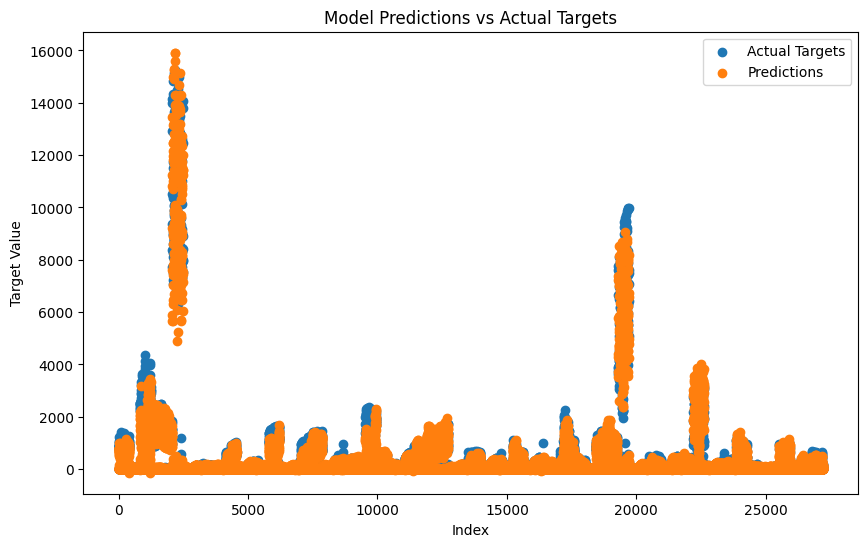

In [31]:
# Extract features from the validation dataset
val_features, val_targets = zip(*[(features.numpy(), targets.numpy()) for features, targets in val_dataset])
val_features = np.concatenate(val_features, axis=0)
val_targets = np.concatenate(val_targets, axis=0)

# Generate predictions
predictions = model.predict(val_features)
predictions = predictions.flatten()
val_targets = val_targets.flatten()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(range(len(val_targets)), val_targets, label='Actual Targets')
plt.scatter(range(len(predictions)), predictions, label='Predictions')
plt.title('Model Predictions vs Actual Targets')
plt.xlabel('Index')
plt.ylabel('Target Value')
plt.legend()
plt.show()



In [33]:
#val_targets.to_excel('val_targets_base.xlsx')
np.savetxt("targets_best.csv", val_targets, delimiter=",")
print(predictions)

[5.26669435e-04 5.46216003e+02 1.41329605e+02 ... 9.10813828e+01
 4.72377434e+01 1.08348595e+02]


In [ ]:
# Extract features from the validation dataset
test_features, test_targets = zip(*[(features.numpy(), targets.numpy()) for features, targets in test_dataset])
test_features = np.concatenate(test_features, axis=0)
test_targets = np.concatenate(test_targets, axis=0)

# Generate predictions
predictions = model.predict(test_features)
predictions = predictions.flatten()
test_targets = test_targets.flatten()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(range(len(test_targets)), test_targets, label='Actual Targets')
plt.scatter(range(len(predictions)), predictions, label='Predictions')
plt.title('Model Predictions vs Actual Targets')
plt.xlabel('Index')
plt.ylabel('Target Value')
plt.legend()
plt.show()


In [35]:
loss, mae = model.evaluate(test_dataset, verbose=1)  # 'mae' for regression task

426/426 [==============================] - 1s 2ms/step - loss: 92.4375 - mean_absolute_error: 92.4375
